## Import

In [1]:
import os
import psycopg2
from dotenv import load_dotenv

import pandas as pd
import numpy as np

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.compose import make_column_selector as selector


# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
plt.style.use('seaborn')

# Affichage cellule
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_row', 1000)
from pprint import pprint

# Chargement du model pour déploiement
import pickle

## Connection à la DB sécurisé via des variables d'environnement

### création de la chaine de connexion

In [2]:


load_dotenv()  # Nécessaire pour charger les variables d'environnement précédemment définies

# Créer une connexion à postgres
connection = psycopg2.connect(host=os.environ.get('PG_HOST'),
                        user=os.environ.get('PG_USER'),
                        password=os.environ.get('PG_PASSWORD'),
                        dbname=os.environ.get('PG_DATABASE'))

connection.autocommit = True  # Assurez-vous que les données sont ajoutées à la base de données immédiatement après les commandes d'écriture.
cursor = connection.cursor()
cursor.execute('SELECT %s as connected;', ('Connection à postgres Réussie!',))
print(cursor.fetchone())

('Connection à postgres Réussie!',)


### Fonction de création du dataframe

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Transformer une requête SELECT en un dataframe pandas
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturellement, nous obtenons une liste de "tupples".
    tupples = cursor.fetchall()
    cursor.close()
    
    # Nous devons juste le transformer en dataframe pandas.
    df = pd.DataFrame(tupples, columns=column_names)
    return df

### Récupération de postgresql au dataframe

In [4]:
conn = connection
column_names = ["user_id","gender", "age", "height", "weight", "duration", "heart_rate", "body_temp", "calorie"]
# Execute the "SELECT *" query
df_db = postgresql_to_dataframe(conn, 
"SELECT persons.user_id as id, gender, age, height, weight, duration, heart_rate, body_temp,calorie FROM calories INNER JOIN persons ON calories.user_id = persons.user_id"
                                , column_names)
df_db.head()

,user_id,gender,age,height,weight,duration,heart_rate,body_temp,calorie
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


In [ ]:
last_df2 = df_db.copy()

In [ ]:
best_df2 = last_df2[['height', 'weight', 'duration', 'age','calorie']]
best_df2

In [ ]:
X = best_df2[['duration']]
# y unidimensionnel
y = best_df2['calorie']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
ridg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
#clf = GridSearchCV(regr)
ridg.fit(X_train, y_train)

In [ ]:
ridg.score(X_test, y_test)

In [ ]:
ridg.score(X_train, y_train)

In [ ]:
# We need to calculate IMC
best_df2['Height_meters'] = best_df2['height']/100

In [ ]:
best_df2['calculated_IMC'] = (best_df2['weight']/best_df2['Height_meters']**2)

In [ ]:
#best_df# charge le dataframe 
##best_df.to_csv('best_df.csv')

In [ ]:
best_df2.to_csv('best_df_with_age.csv')

In [ ]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = best_df2[['age','duration','calculated_IMC']]
# y unidimensionnel
y = best_df2['calorie']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

In [ ]:
#clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X, y)
#clf.score(X, y)

In [ ]:
ridg = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
#clf = GridSearchCV(regr)
ridg.fit(X_train, y_train)

In [ ]:
ridg.score(X_train, y_train)

In [ ]:
ridg.score(X_test, y_test)

In [ ]:
from sklearn.linear_model import Ridge

parameters = {'alpha':[1, 10],
             'normalize' : [True, False],
             'solver' : ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]}

# define the model/ estimator
model_R = Ridge()

# define the grid search
Ridge_reg= GridSearchCV(model_R, parameters, scoring='r2',cv=5)

#fit the grid search
Ridge_reg.fit(X_train,y_train)


In [ ]:

# define the grid search
Ridge_reg= GridSearchCV(model_R, parameters, scoring='r2',cv=5)

#fit the grid search
Ridge_reg.fit(X_train,y_train)

In [ ]:
# best estimator
print(Ridge_reg.best_estimator_)

# best model
best_model2 = Ridge_reg.best_estimator_
best_model2.fit(X_train,y_train)

In [ ]:
Ridge_reg.best_estimator_

In [ ]:
## fonction custom grid search

In [ ]:
ridge_with_grid = Ridge(alpha=10, solver='saga')
#clf = GridSearchCV(regr)
ridge_with_grid.fit(X_train, y_train)

In [ ]:
ridge_with_grid.score(X_train, y_train)

In [ ]:
ridge_with_grid.score(X_test, y_test)

In [ ]:
y_pred = ridge_with_grid.predict(X_test)

In [ ]:
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(ridge_with_grid, scoring='r2')
visualizer.fit(X_train, y_train)
visualizer.show()


In [ ]:

regr = RandomForestRegressor(max_depth= 4, max_leaf_nodes= 20, n_estimators= 300,random_state=0)
#clf = GridSearchCV(regr)
regr.fit(X_train, y_train)

In [ ]:
regr.score(X_train, y_train)

In [ ]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(regr, scoring='r2')
visualizer.fit(X_train, y_train)      
visualizer.show()   

In [ ]:
clf.best_params_

In [ ]:
from sklearn import linear_model

LS = linear_model.Lasso(alpha=np.linspace(0, 0.2, 21))

GR_lasso = GridSearchCV(LS, parameters)
GR_lasso.fit(X_train, y_train)

In [ ]:
GR_lasso.bet

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold
from numpy import arange

model_lasso_cv = Lasso(alpha=0.01)
# define model evaluation method
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
#grid = dict()
#grid['alpha'] = arange(0, 1, 0.01)
# define search
#search = GridSearchCV(model, grid, scoring='r2', cv=cv, n_jobs=-1)
# perform the search
model_lasso_cv.fit(X_train, y_train)


In [ ]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(model_lasso_cv, scoring='r2')
visualizer.fit(X_train, y_train)      
visualizer.show() 


In [ ]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=12)


model = Lasso(alpha=0.01)
visualizer = LearningCurve(
    model, cv=cv, scoring='r2'
)

visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()  

In [ ]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(results, scoring='r2')
visualizer.fit(X_train, y_train)      
visualizer.show() 

In [ ]:
### regression lineaire

In [ ]:
parameters = {'fit_intercept': [True, False],
                  'normalize'    : [True, False],
                  'copy_X' :  [True, False],
                  'n_jobs'    : [0,1,2,3,4,5,6,7,8,9,10],
                  'positive': [True, False]
                 }

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
grid_GBR = GridSearchCV(estimator=reg, param_grid = parameters, cv = 2, n_jobs=-1)

In [ ]:
grid_GBR.fit(X_train, y_train)

In [ ]:
grid_GBR.best_params_

In [ ]:
grid_GBR.score(X_train, y_train)

In [ ]:
reg2 = LinearRegression(copy_X= True,fit_intercept=True,normalize=True,positive=True)

In [ ]:
reg2.fit(X_train, y_train)

In [ ]:
reg2.score(X_train, y_train)

In [ ]:

from yellowbrick.model_selection import LearningCurve
visualizer = LearningCurve(reg2, scoring='r2')
visualizer.fit(X, y)      
visualizer.show() 

# yellow bricks random forest regressor

In [ ]:
df_RFG_curve = best_df2.copy()

In [ ]:
from sklearn.model_selection import (
    cross_val_score,
    train_test_split
)

from yellowbrick.model_selection import (
    learning_curve,
    validation_curve,
    cv_scores
)

n_estimators = 300
max_leaf_nodes = 20
RANDOM_STATE = 42 
CV = 10
max_depth = 4
SCORING = "r2"
%matplotlib inline

In [ ]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = best_df2[['age','duration','calculated_IMC']]
# y unidimensionnel
y = best_df2['calorie']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.30, random_state=RANDOM_STATE 
)

In [ ]:
rf2 = RandomForestRegressor(random_state=RANDOM_STATE,
                           n_estimators=n_estimators,
                           max_leaf_nodes=max_leaf_nodes,
                          max_depth=max_depth)
rf2.fit(X_train, y_train)

In [ ]:
learning_curve(
    estimator=rf2,
    X=X_train,
    y=y_train,
    cv=CV,
    train_sizes=np.linspace(0.1,1.0,5),
    random_state=RANDOM_STATE,
    scoring=SCORING,
)

In [ ]:
validation_curve( 
    estimator=rf2, 
    X=X_train, 
    y=y_train, 
    param_name="max_depth", 
    param_range=np.arange(1, 5), 
    cv=CV,  
    random_state=RANDOM_STATE 
)

In [ ]:
dt_md3 = RandomForestRegressor( 
    max_depth=3, random_state=RANDOM_STATE 
)
learning_curve( 
    estimator=dt_md3, 
    X=X_train, 
    y=y_train, 
    cv=CV, 
    train_sizes=np.linspace(0.1,1.0,5),  
    show=True, 
    random_state=RANDOM_STATE, 
    scoring=SCORING, 
)

In [ ]:
grid_GBR.best_params_.score(X_train, y_train)

In [ ]:
ohe=OneHotEncoder(sparse=False)

ct=make_column_transformer((ohe,['gender']))
data_ct=ct.fit_transform(df_db)

# Encodage sur le genre et retransformation en dataframe pandas nommé dum
ohe_True=OneHotEncoder(sparse=True)
ohe_with_sparse=ohe_True.fit_transform(df_db['gender'].values.reshape(-1,1)).toarray()
ohe_with_sparse

dum_scaler=pd.get_dummies(df_db,columns=['gender'],prefix='',prefix_sep='')

## Modele

In [ ]:
# # utilisation des doubles crochets pour renvoyer un DataFrame pour la variable  X
X = dum_scaler.drop(['calorie','user_id'] , axis=1)
# y unidimensionnel
y = dum_scaler['calorie']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [ ]:
def select_features(X_train, y_train, X_test, k_value='all'):
    fs = SelectKBest(score_func=chi2, k=k_value)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [ ]:
# feature selection
X_train, X_test, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

In [ ]:
# what are scores for the features
names = []
values = []
for i in range(len(fs.scores_)):
    names.append(X.columns[i])
    values.append(fs.scores_[i])
chi_list = zip(names, values)

# plot the scores
plt.figure(figsize=(10,4))
sns.barplot(x=names, y=values)
plt.xticks(rotation = 90)
plt.show()

In [ ]:
d = df_db[['duration', 'age', 'weight', 'calorie']]

In [ ]:
X = d.drop(['calorie'], axis=1)
y = d.calorie

In [ ]:
X.head(1)

In [ ]:
# split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# create a ml model using pipeline
model = make_pipeline(MinMaxScaler(), LinearRegression())
# fit the model on training data
model.fit(X_train, y_train)

In [ ]:
# test the model on test set
y_pred = model.predict(X_test)

# measure error
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squre Error:", rmse)

In [ ]:
model.score(X_test, y_test)

In [ ]:
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))         # Finalize and render the figure

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

In [ ]:
plt.subplots(1, figsize=(10,10))
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("R2 Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
dataframe = df_db[['duration', 'age', 'height','weight', 'calorie']]

In [ ]:
best_df = df_db['height', 'weight','df_db', 'calorie']
best_df

In [ ]:
# We need to calculate IMC
dataframe['Height_meters'] = dataframe['height']/100
dataframe['calculated_IMC'] = (dataframe['weight']/dataframe['Height_meters']**2)

dataframe.head()

In [ ]:
X = dataframe.drop(['height', 'weight', 'Height_meters','calorie'], axis=1)
y = dataframe.calorie

In [ ]:
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, y_train.shape
X_test.shape, y_test.shape

In [ ]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

In [ ]:
predictions = lm.predict(X_test)

In [ ]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [ ]:
print('Score:', model.score(X_test, y_test))

In [ ]:
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import LearningCurve

visualizer = LearningCurve(model, scoring='r2')
visualizer.fit(X_train, y_train)      
visualizer.show()          

In [ ]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

In [ ]:
best_df

In [ ]:
data_test = df_db.copy()

In [ ]:
X = data_test[['duration']]
y = data_test.calorie

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [ ]:
a = linear_model.LinearRegression()
scores = cross_val_score(a, X_train, y_train, cv=5)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
scores_test = cross_val_score(a, X_test, y_test, cv=5)

In [ ]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores_test.mean(), scores_test.std()))

In [ ]:
a = a.fit(X_train, y_train)

In [ ]:
a.score(X_test,y_test)

In [ ]:
a.score(X_train,y_train)

In [ ]:
from sklearn.model_selection import ShuffleSplit
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
tr_val = cross_val_score(a, X_train, y_train, cv=cv).mean()

In [ ]:
tr_val

In [ ]:
tr_val_test = cross_val_score(a, X_test, y_test, cv=cv)

In [ ]:
tr_val_test.mean()

In [ ]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1000)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = linear_model.LinearRegression().fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

In [ ]:
import numpy as np
from sklearn.model_selection import KFold

kf = KFold(n_splits=2)
for train, test in kf.split(X):
    print("%s %s" % (train, test))

In [ ]:
import numpy as np
from sklearn.model_selection import RepeatedKFold

random_state = 12883823
rkf = RepeatedKFold(n_splits=2, n_repeats=2, random_state=random_state)
for train, test in rkf.split(X):
    print("%s %s" % (train, test))

In [ ]:
fold = df_db.copy()

In [ ]:
kfold = KFold(3, True, 1)

In [ ]:
# enumerate splits
for train, test in kfold.split(df_kfold):
	print('train: %s, test: %s' % (train, test))

In [27]:
zzz = df_db.copy()

In [28]:
X = zzz[['duration', 'age']]
y = zzz.calorie

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=100)

In [30]:
from sklearn.model_selection import cross_validate
def cross_validation(model, _X, _y, _cv=15):
 
      _scoring = ['r2']
      results = cross_validate(estimator=model,
                               X=_X,
                               y=_y,
                               cv=_cv,
                               scoring=_scoring,
                               return_train_score=True)
      
      return results
              

In [31]:
cross_validation(LinearRegression(), X_train, y_train, 5)

{'fit_time': array([0.01172686, 0.00662017, 0.00502419, 0.00532699, 0.00548077]),
 'score_time': array([0.00379205, 0.00558996, 0.00271201, 0.00283599, 0.00544596]),
 'test_r2': array([0.93209078, 0.93004194, 0.93372078, 0.93208426, 0.93921315]),
 'train_r2': array([0.93399831, 0.9345417 , 0.93350303, 0.93400173, 0.93222686])}

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import (LinearRegression, HuberRegressor,
                              	  RANSACRegressor, TheilSenRegressor)

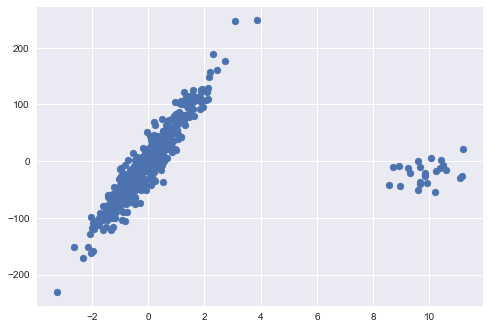

In [33]:
N_SAMPLES = 500
N_OUTLIERS = 25

X, y, coef = datasets.make_regression(
    n_samples=N_SAMPLES, 
    n_features=1, 
    n_informative=1, 
    noise=20, 
    coef=True, 
    random_state=42
)

coef_list = [["original_coef", float(coef)]]

# add outliers               
np.random.seed(42)
X[:N_OUTLIERS] = 10 + 0.75 * np.random.normal(size=(N_OUTLIERS, 1))
y[:N_OUTLIERS] = -15 + 20 * np.random.normal(size=N_OUTLIERS)

plt.scatter(X, y)

In [34]:
lr = LinearRegression().fit(X, y)
coef_list.append(["linear_regression", lr.coef_[0]])

In [35]:

plotline_X = np.arange(X.min(), X.max()).reshape(-1, 1)

fit_df = pd.DataFrame(
    index = plotline_X.flatten(),
    data={"linear_regression": lr.predict(plotline_X)}
)

In [43]:
plotline_X

array([[-3.24126734],
       [-2.24126734],
       [-1.24126734],
       [-0.24126734],
       [ 0.75873266],
       [ 1.75873266],
       [ 2.75873266],
       [ 3.75873266],
       [ 4.75873266],
       [ 5.75873266],
       [ 6.75873266],
       [ 7.75873266],
       [ 8.75873266],
       [ 9.75873266],
       [10.75873266]])

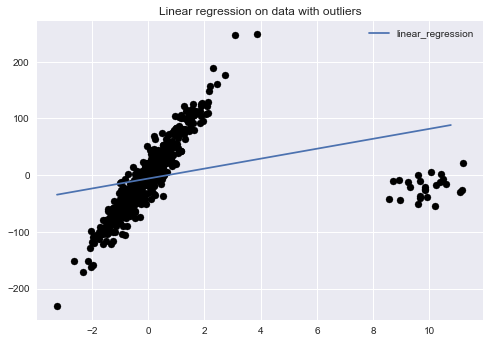

In [36]:

fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression on data with outliers");

In [37]:

huber = HuberRegressor().fit(X, y)
fit_df["huber_regression"] = huber.predict(plotline_X)
coef_list.append(["huber_regression", huber.coef_[0]])

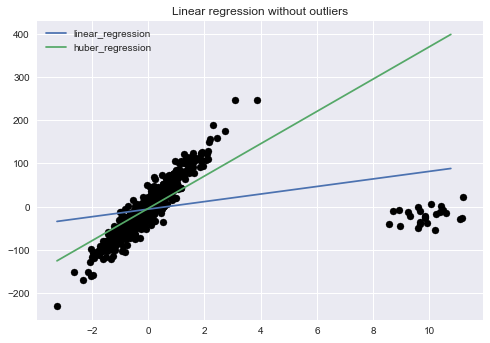

In [39]:

fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression without outliers");

In [41]:
ransac = RANSACRegressor(random_state=42).fit(X, y)
fit_df["ransac_regression"] = ransac.predict(plotline_X)
ransac_coef = ransac.estimator_.coef_
coef_list.append(["ransac_regression", ransac.estimator_.coef_[0]])

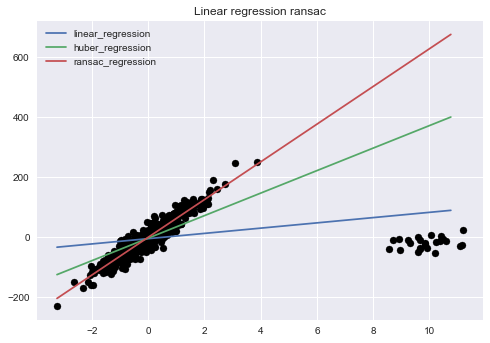

In [42]:
fix, ax = plt.subplots()
fit_df.plot(ax=ax)
plt.scatter(X, y, c="k")
plt.title("Linear regression ransac");